To set up the code, a template for astrometric measurement should be declared first.  

'AstroMetricTemplate.py' help transforming into different celestial coordinate  

some packages like numpy are also required.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import AstroMetricTemplate as tp

The template file has defined a function to read the data and translate into a data structure -> NodeList, where node here is the class of celestial coordinates.  

You can check the 'AstroMetricTemplate.py' to find more specific details.

In [10]:
DataList = tp.ReadData('hii_625.txt')
N = DataList.get_length()

First i have to plot the data for a better understanding of what i am doing.  

Because the deviation is tiny, it will be more intuitive to use mas rather than radians

In [11]:
def radians_to_mas(radians):
    return radians/np.pi*180*3600*1000
def mas_to_radians(mas):
    return mas/1000/3600/180*np.pi

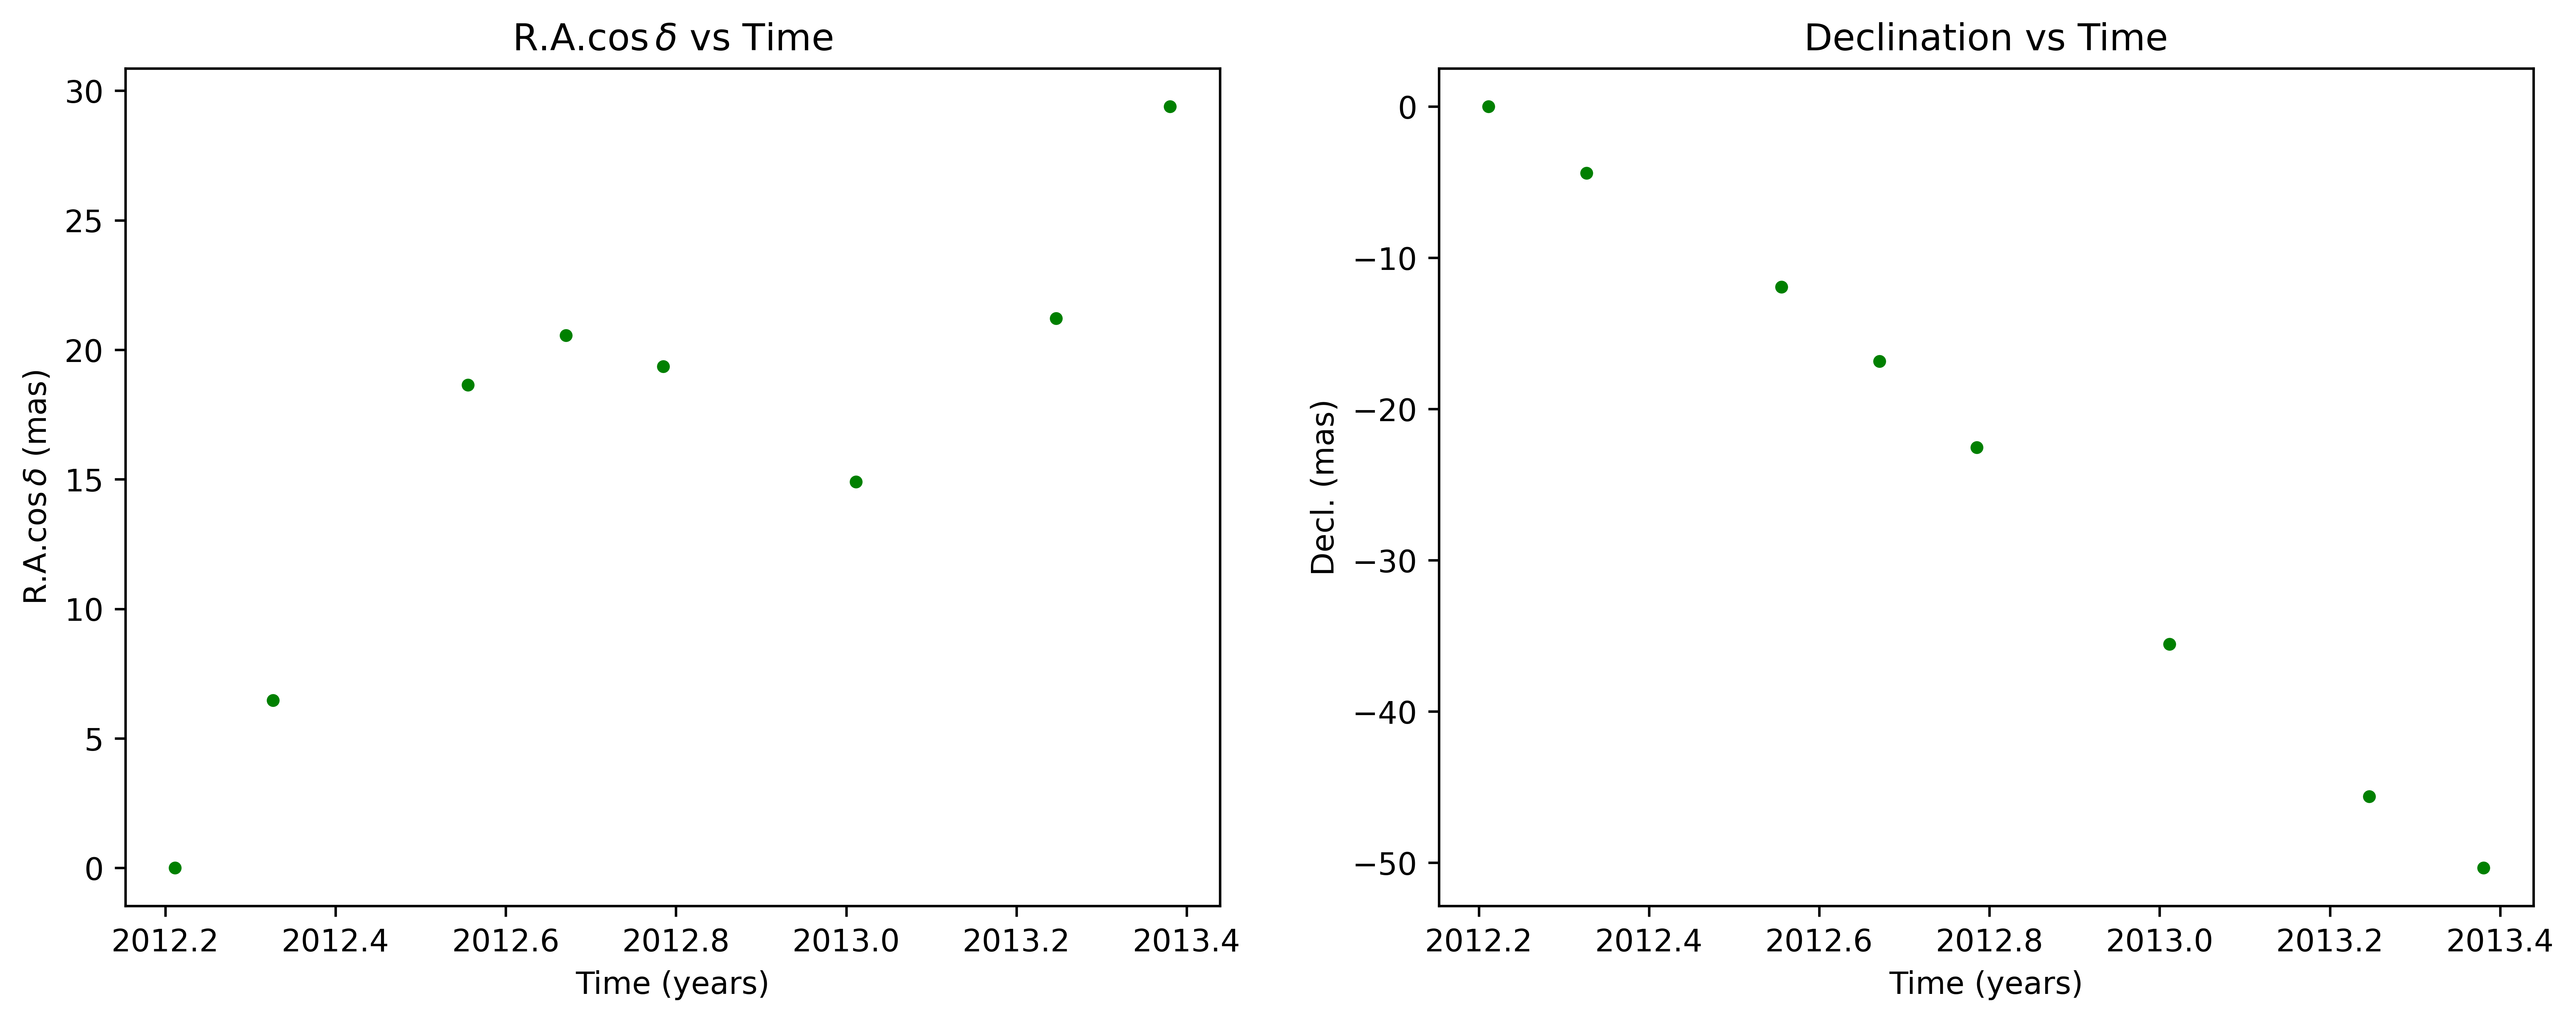

In [12]:
alpha_epoch = DataList.get_node(0).get_longitude()
t_epoch = DataList.get_node(0).get_Year()
delta_epoch = DataList.get_node(0).get_latitude()

plt.figure(figsize=(14, 5), dpi=600)
#RA plot
plt.subplot(1,2,1)
for i in range(N):
    Node_In:tp.CelestialCoordinate = DataList.get_node(i)
    t_plot = Node_In.get_Year()
    plt.scatter(t_plot,np.cos(Node_In.get_latitude())*radians_to_mas(Node_In.get_longitude()-alpha_epoch),s=10, c='g')
    #plt.errorbar(t_plot,radians_to_mas(Node_In.get_ra()) ,yerr=radians_to_mas(Node_In.get_err_ra()))
plt.xlabel('Time (years)')
plt.ylabel('R.A.$\cos\delta$ (mas)')
plt.title('R.A.$\cos\delta$ vs Time')

#DEC plot
plt.subplot(1,2,2)
for i in range(N):
    Node_In:tp.CelestialCoordinate = DataList.get_node(i)
    t_plot = Node_In.get_Year()
    plt.scatter(t_plot,radians_to_mas(Node_In.get_latitude()-delta_epoch),s=10, c='g')

plt.xlabel('Time (years)')
plt.ylabel('Decl. (mas)')
plt.title('Declination vs Time')
plt.show()


The data shown here indicates a sinusoid plus a linear function.  

While the position of the orbiting Earth differs from time, the sinusoid is quite easy to understand.

The detailed discussion of the curve will be included in the PDF file 'Parallax.pdf'

The next step is to fit the data with the Astrometric model

Here I declared a class of samples:

the features of the sample node is described by a nodelist structure FeatureList, which includes nodes of features.

the responses to the sample node is described by a nodelist structure ResponseList, which includes nodes of responses.

'SampleClass.py' is a template for such a sample fit

In [13]:
import SampleClass as sc
SampleList = sc.NodeList()
for i in range(N):
#initialize
    SampleNode = sc.SampleNode()
    Features = sc.NodeList()
    Responses = sc.NodeList()
    #get data
    Node_In:tp.CelestialCoordinate = DataList.get_node(i)
    r_E = Node_In.GetEarthDistance()
    lambda_E = Node_In.GetEarthLambda()
    t = Node_In.get_Year() #Julian Date

    #Earth Node
    Node_Earth = tp.CelestialCoordinate(np.pi+lambda_E,0.0,0.0,0.0,Node_In.get_JulianDate()).Ecliptic2Equator() #Earth Node in Equatorial Coordinate
    #Geometry in Cartesian Coordinate
    p = np.array([-np.sin(Node_In.get_longitude()), -np.cos(Node_In.get_longitude()), 0.0])
    q = np.array([-np.sin(Node_In.get_latitude())*np.cos(Node_In.get_longitude()), np.sin(Node_In.get_latitude())*np.sin(Node_In.get_longitude()), np.cos(Node_In.get_latitude())])
    r = Node_In.normal_vector()
    
    b = r_E* Node_Earth.normal_vector()
    #Consider Roemer Delay
    t_B = t + np.dot(r,b)/tp.c_AU_yr
    #Orbit Features
    OrbitFeature_1 = -np.dot(q,b)
    OrbitFeature_2 = -np.dot(p,b)

    #Features and Responses
    Features.add_node(sc.FeatureNode(1,'zero order'))
    Features.add_node(sc.FeatureNode(t_B-t_epoch,'time feature'))
    Features.add_node(sc.FeatureNode(OrbitFeature_1,'orbit feature for decl'))
    Features.add_node(sc.FeatureNode(OrbitFeature_2,'orbit feature for ra*'))

    ra_s = Node_In.get_longitude()*np.cos(Node_In.get_latitude()) - alpha_epoch*np.cos(Node_In.get_latitude())
    err_ra_s = np.sqrt( (Node_In.get_err_long() * np.cos(Node_In.get_latitude()))**2 + (Node_In.get_longitude()*np.sin(Node_In.get_latitude())*Node_In.get_err_lat())**2)
    Responses.add_node(sc.ResponseNode(Node_In.get_latitude()-delta_epoch ,Node_In.get_err_lat(),'latitude'))
    Responses.add_node(sc.ResponseNode(ra_s,err_ra_s,'ra_s')) #ra_*

    #link to SampleNode
    SampleNode.link_FeatureList(Features)
    SampleNode.link_ResponseList(Responses)
    #add to SampleList
    SampleList.add_node(SampleNode)


The fit code is a simple weighted linear least square fit, where the difference is that the fitted samples have more than one responses.

This can be solved by doing matrix multiply with declination and R.A. simultaneously.

In [14]:
def WLS(SampleList:sc.NodeList):
    #initialize
    N = SampleList.get_length() #number of samples
    FeatureList = SampleList.get_node(0).get_FeatureList()
    p = 5 #number of parameters
    DoF = 2*N-p

    X_decl = np.zeros((N,p))
    X_ra = np.zeros((N,p))
    y_decl = np.zeros((N,1))
    y_ra = np.zeros((N,1))
    B_decl = np.zeros((N,N))
    B_ra = np.zeros((N,N))

    chi_square = 0
    l = 0
    r = 1e-5
    while(l<r):
        m = (l+r)/2
        sigma_sys = m #radians

        for i in range(N):
            SampleNode = SampleList.get_node(i)
            ResponseList = SampleNode.get_ResponseList()
            FeatureList = SampleNode.get_FeatureList()
            y_decl[i] = ResponseList.get_node(0).get_response()
            y_ra[i] = ResponseList.get_node(1).get_response()
            B_decl[i][i] = 1 / ( (ResponseList.get_node(0).get_err())**2+ sigma_sys**2 )
            B_ra[i][i] = 1 / ( (ResponseList.get_node(1).get_err())**2+ sigma_sys**2 )

            X_decl[i][0] = FeatureList.get_node(0).get_feature()
            X_decl[i][1] = 0
            X_decl[i][2] = FeatureList.get_node(1).get_feature()
            X_decl[i][3] = 0
            X_decl[i][4] = FeatureList.get_node(2).get_feature()

            X_ra[i][0] = 0
            X_ra[i][1] = FeatureList.get_node(0).get_feature()
            X_ra[i][2] = 0
            X_ra[i][3] = FeatureList.get_node(1).get_feature()
            X_ra[i][4] = FeatureList.get_node(3).get_feature()

        beta_WLS = np.linalg.inv( X_decl.T@B_decl@X_decl +X_ra.T@B_ra@X_ra )@(X_decl.T@B_decl@y_decl+X_ra.T@B_ra@y_ra)
        
        chi_square = ((y_decl-X_decl@beta_WLS).T@B_decl@(y_decl-X_decl@beta_WLS) + (y_ra-X_ra@beta_WLS).T@B_ra@(y_ra-X_ra@beta_WLS))/DoF
        if (chi_square > 1.003):   
            l = m
        else:
            if (chi_square < 1.002):  
                r = m
            else:
                break
        var_beta_WLS = np.linalg.inv( X_decl.T@B_decl@X_decl +X_ra.T@B_ra@X_ra )
    return radians_to_mas(beta_WLS), radians_to_mas(np.sqrt(var_beta_WLS)), chi_square , sigma_sys

print('WLS result =', WLS(SampleList))

WLS result = (array([[  1.65170967],
       [  5.19481323],
       [-44.37647464],
       [ 19.48072555],
       [  7.31097116]]), array([[0.19205685, 0.01186522,        nan,        nan,        nan],
       [0.01186522, 0.18134895,        nan,        nan,        nan],
       [       nan,        nan, 0.28769024, 0.01381128, 0.03613523],
       [       nan,        nan, 0.01381128, 0.26955611, 0.05883965],
       [       nan,        nan, 0.03613523, 0.05883965, 0.15394547]]), array([[1.0024914]]), 1.3387203216552735e-09)


/var/folders/9r/d810_63d7yx101gkrv_41ygm0000gn/T/ipykernel_39591/589425427.py:54: RuntimeWarning: invalid value encountered in sqrt
  return radians_to_mas(beta_WLS), radians_to_mas(np.sqrt(var_beta_WLS)), chi_square , sigma_sys


Since we are conducting linear fit, the result here simply represents the coefficients of each features. In this code we have,
$$
\mu_\delta = (-44.38 \pm 0.29) \ \mathrm{mas/yr} \\
\mu_{\alpha *} = (19.48 \pm 0.27) \ \mathrm{mas/yr} 
$$
Note that the variance here are 1 SD.

The other underlying physics will be revealed if the results are plotted below:

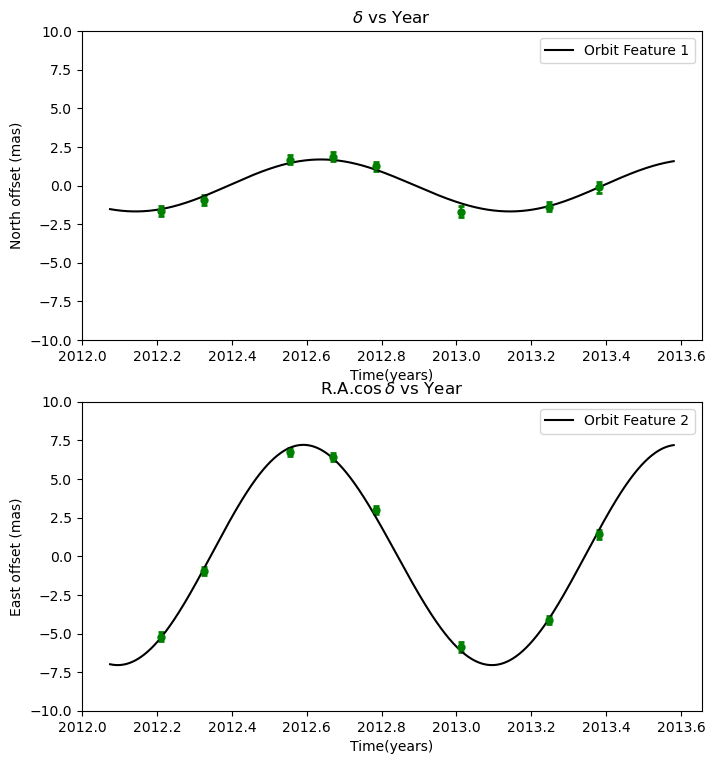

In [39]:
#params obtained
params = np.array([  1.65171967,5.19470275,-44.37645348,19.48086502,7.31131175])
sigma_sys = 1.3387203216552735e-09
#initialize
JulianDate_epoch = DataList.get_node(0).get_JulianDate()
JulianDate_plot = np.linspace(JulianDate_epoch-50,JulianDate_epoch+500,1000)

Node_In = tp.CelestialCoordinate(alpha_epoch,delta_epoch,0.0,0.0,JulianDate_plot)

r_E = Node_In.GetEarthDistance()
lambda_E = Node_In.GetEarthLambda()
t = Node_In.get_Year() #Julian Date

#Earth Node
Node_Earth = tp.CelestialCoordinate(np.pi+lambda_E,0.0,0.0,0.0,Node_In.get_JulianDate()).Ecliptic2Equator() #Earth Node in Equatorial Coordinate
#Geometry in Cartesian Coordinate
alpha = Node_In.get_longitude()
delta = Node_In.get_latitude()

p = np.array([-np.sin(alpha), -np.cos(alpha), 0.0])
q = np.array([-np.sin(delta)*np.cos(alpha), np.sin(delta)*np.sin(alpha), np.cos(delta)])
r = Node_In.normal_vector()
    
b = r_E* Node_Earth.normal_vector()
#Consider Roemer Delay
t_B = t + np.dot(r,b)/tp.c_AU_yr
#Orbit Feature
OrbitFeature_1 = -np.dot(q,b)
OrbitFeature_2 = -np.dot(p,b)

#plot section
plt.figure(figsize=(8, 9), dpi=100)
plt.subplot(2,1,1)
for i in range(N):
    PNode = DataList.get_node(i)
    delta_p = PNode.get_latitude()
    delta_p_err = np.sqrt(PNode.get_err_lat()**2+sigma_sys**2)
    t = PNode.get_Year()
    plt.errorbar(t,radians_to_mas(delta_p-delta_epoch)-params[0]-params[2]*(t-t_epoch),yerr=radians_to_mas(delta_p_err),c='g',capsize=2,capthick=2,markersize=5,fmt='o')
plt.plot(Node_In.get_Year(),OrbitFeature_1*params[4],'black',label='Orbit Feature 1')
plt.legend()
plt.xlabel('Time(years)')
plt.ylabel('North offset (mas)')
plt.ylim(-10,10)
plt.title('$\delta$ vs Year')

plt.subplot(2,1,2)
for i in range(N):
    PNode = DataList.get_node(i)
    alpha_p = PNode.get_longitude()
    delta_p = PNode.get_latitude()
    ra_p_err = np.sqrt(PNode.get_err_long()**2 + (alpha_p*np.sin(delta_p)*PNode.get_err_lat())**2+ sigma_sys**2)
    t = PNode.get_Year()
    plt.errorbar(t,radians_to_mas(alpha_p-alpha_epoch)*np.cos(delta_p)-params[1]-params[3]*(t-t_epoch),yerr = radians_to_mas(ra_p_err*np.cos(delta_p)) ,c='g',capsize=2,capthick=2,markersize=5,fmt='o')
plt.plot(Node_In.get_Year(),OrbitFeature_2*params[4],'black',label='Orbit Feature 2')
plt.legend()
plt.xlabel('Time(years)')
plt.ylabel('East offset (mas)')
plt.ylim(-10,10)
plt.title('R.A.$\cos\delta$ vs Year')
plt.show()


As is shown in the figure, if the proper motion is canceled, the declination deviation caused by parallax can be very similar to a sine curve.

From the data fit above, we are finally able to derive the distance to the star $D$ using $\pi$.

In [40]:
D = 1/params[4]
D_unc = np.sqrt(np.diag(WLS(SampleList)[1]))[4]/params[4]**2
print('D =',D,'kpc')
print('D_unc =',D_unc,'kpc')

D = 0.13677436200145618 kpc
D_unc = 0.007339945726296031 kpc


/var/folders/9r/d810_63d7yx101gkrv_41ygm0000gn/T/ipykernel_39591/589425427.py:54: RuntimeWarning: invalid value encountered in sqrt
  return radians_to_mas(beta_WLS), radians_to_mas(np.sqrt(var_beta_WLS)), chi_square , sigma_sys
